In [1]:
'''The code generates a unified metadata matrix that links clinical information to sequencing run IDs. It begins by extracting patient IDs from GEO Series Matrix files and is designed to handle multiple sampling scenarios, such as:
- Patients with paired blood and biopsy samples
- Individuals with only one sample type
- Patients with multiple biopsies taken from different anatomical sites
Because the raw files on the server are named using SRR identifiers, which do not appear in the Series Matrix, the script uses SRA metadata tables to map GEO Accession IDs (GSM) to their corresponding SRA Run IDs (SRR).
Once the metadata is fully linked, cleaned, and ready, the script proceeds to process the AIRRPORT results. It performs an analysis comparing AIRRPORT output between biopsy and blood samples by calculating unique CDR3 counts from raw Parquet files. The script uses a caching mechanism to accelerate processing and generates a log-transformed violin plot annotated with median values to visualize tissue-specific richness distributions. The analysis is performed once for biopsy versus blood samples and again after stratifying by disease type including UC, CD, and Control.'''

'The code generates a unified metadata matrix that links clinical information to sequencing run IDs. It begins by extracting patient IDs from GEO Series Matrix files and is designed to handle multiple sampling scenarios, such as:\n- Patients with paired blood and biopsy samples\n- Individuals with only one sample type\n- Patients with multiple biopsies taken from different anatomical sites\nBecause the raw files on the server are named using SRR identifiers, which do not appear in the Series Matrix, the script uses SRA metadata tables to map GEO Accession IDs (GSM) to their corresponding SRA Run IDs (SRR).\nOnce the metadata is fully linked, cleaned, and ready, the script proceeds to process the AIRRPORT results. It performs an analysis comparing AIRRPORT output between biopsy and blood samples by calculating unique CDR3 counts from raw Parquet files. The script uses a caching mechanism to accelerate processing and generates a log-transformed violin plot annotated with median values to

In [2]:
import os
import glob
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. PATH CONFIGURATION
# ==========================================
BASE_DIR = "/home/dsi/linoym/airrport/Thesis/bulk_analysis"

PATHS = {
    "Biopsy": {
        "raw_counts": "/dsi/efroni-lab/AIRRPORT/bulk_IBD/biopsy/airrport_results_after_star",
        "matrix": os.path.join(BASE_DIR, "GSE193677_series_matrix.txt.gz"),
        "sra": os.path.join(BASE_DIR, "Biopsy_SraRunTable.csv"),
        "cache": os.path.join(BASE_DIR, "biopsy_cdr3_counts_cache.csv"),
        "id_col": "GSM_ID_biopsy",
        "run_col": "Run_biopsy",
        "disease_col": "Disease_biopsy"
    },
    "Blood": {
        "raw_counts": "/dsi/efroni-lab/AIRRPORT/bulk_IBD/blood/CDR3_match_results/aho_6RF",
        "matrix": os.path.join(BASE_DIR, "GSE186507_series_matrix.txt.gz"),
        "sra": os.path.join(BASE_DIR, "Blood_SraRunTable.csv"),
        "cache": os.path.join(BASE_DIR, "blood_cdr3_counts_cache.csv"),
        "id_col": "GSM_ID_blood",
        "run_col": "Run_blood",
        "disease_col": "Disease_blood"
    }
}

METADATA_OUTPUT = os.path.join(BASE_DIR, "paired_blood_biopsy_metadata_FULL.csv")
PLOT_DIR = os.path.join(BASE_DIR, "plots")
if not os.path.exists(PLOT_DIR): os.makedirs(PLOT_DIR)

FORCE_RELOAD = False

In [3]:
# ==========================================
# 2. METADATA & DATA LOADING FUNCTIONS
# ==========================================
def parse_geo_matrix(filepath):
    """Parses GEO Series Matrix file to extract Title, GSM_ID, BioSample, and Disease."""
    metadata = {}
    with gzip.open(filepath, 'rt', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()
            if "!series_matrix_table_begin" in line: break
            parts = line.replace('"', '').split('\t')[1:]
            
            if line.startswith("!Sample_title"):
                metadata['Title'] = parts
            elif line.startswith("!Sample_geo_accession"):
                metadata['GSM_ID'] = parts
            elif line.startswith("!Sample_relation") and "BioSample:" in line:
                urls = [val.replace("BioSample: ", "").strip() for val in parts]
                metadata['BioSample'] = [url.split('/')[-1] for url in urls]
            elif line.startswith("!Sample_characteristics") and "ibd_disease:" in line:
                metadata['Disease'] = [
                    val.split("ibd_disease:")[1].strip() if "ibd_disease:" in val else pd.NA 
                    for val in parts
                ]

    df = pd.DataFrame(metadata)
    if 'Title' in df.columns:
        df['patient_id'] = df['Title'].str.extract(r'(\d+)')
    return df

def generate_full_metadata():
    """Generates the master metadata table merging Blood, Biopsy, and SRA info."""
    print("--- Generating Metadata ---")
    meta_blood = parse_geo_matrix(PATHS["Blood"]["matrix"])
    meta_biopsy = parse_geo_matrix(PATHS["Biopsy"]["matrix"])
    
    paired = pd.merge(meta_blood, meta_biopsy, on="patient_id", how="outer", suffixes=('_blood', '_biopsy'))

    for tissue, cfg in PATHS.items():
        try:
            sra_df = pd.read_csv(cfg["sra"])
            sra_clean = sra_df[['Sample Name', 'Experiment', 'Run']].rename(columns={
                'Sample Name': cfg["id_col"],
                'Experiment': f'Experiment_{tissue.lower()}',
                'Run': cfg["run_col"]
            })
            paired = pd.merge(paired, sra_clean, on=cfg["id_col"], how='left')
            print(f"✅ {tissue} SRA info added.")
        except Exception as e:
            print(f"❌ Error reading {tissue} SRA: {e}")

    paired.to_csv(METADATA_OUTPUT, index=False)
    return paired

def analyze_parquet_files(folder_path):
    """Scans folder for parquets and counts unique CDR3s."""
    data = []
    files = glob.glob(os.path.join(folder_path, "*.parquet"))
    print(f"   --> Processing {len(files)} files in {os.path.basename(folder_path)}...")
    for filepath in files:
        try:
            df = pd.read_parquet(filepath)
            if "CDR3_match" in df.columns:
                data.append({
                    'Sample': os.path.basename(filepath).replace('.parquet', ''),
                    'Unique_CDR3_Count': df["CDR3_match"].nunique()
                })
        except Exception: pass
    return pd.DataFrame(data)

def load_counts(tissue_type, force=False):
    """Loads counts from cache if available, else processes raw files."""
    cfg = PATHS[tissue_type]
    if os.path.exists(cfg["cache"]) and not force:
        print(f"--- Loading {tissue_type} from Cache ---")
        df = pd.read_csv(cfg["cache"])
    else:
        print(f"--- Processing {tissue_type} Raw Files ---")
        df = analyze_parquet_files(cfg["raw_counts"])
        if not df.empty: df.to_csv(cfg["cache"], index=False)
    
    if not df.empty: df['Tissue'] = tissue_type
    return df

def merge_counts_with_metadata(counts_df, metadata_df, tissue_type):
    """Links count data to metadata via Filename <-> Run ID matching."""
    cfg = PATHS[tissue_type]
    valid_ids = metadata_df[cfg["run_col"]].dropna().astype(str).unique()
    
    print(f"   Linker: Matching {len(counts_df)} {tissue_type} samples to {len(valid_ids)} IDs...")
    
    def get_id(filename):
        for vid in valid_ids:
            if vid in filename: return vid
        return None

    counts_df['Matched_ID'] = counts_df['Sample'].apply(get_id)
    merged = pd.merge(counts_df, metadata_df, left_on='Matched_ID', right_on=cfg["run_col"], how='inner')
    merged['Condition'] = merged[cfg["disease_col"]]
    merged = merged.drop_duplicates(subset=['Sample'])
    
    merged['Condition'] = merged['Condition'].astype(str)
    condition_map = {'control': 'Control', 'uc': 'UC', 'cd': 'CD'}
    for k, v in condition_map.items():
        merged.loc[merged['Condition'].str.contains(k, case=False), 'Condition'] = v
        
    return merged

# ==========================================
# 3. PLOTTING FUNCTIONS
# ==========================================

# PLOT 1: General Comparison (Biopsy vs Blood)
def plot_general_comparison(df):
    """Creates a simple violin plot comparing Biopsy vs Blood (no disease split)."""
    if df.empty: return
    
    df = df.copy()
    df['Log_Value'] = np.log10(df['Unique_CDR3_Count'] + 1)
    
    medians = df.groupby('Tissue')['Unique_CDR3_Count'].median()
    labels = [f"Biopsy\n(Median: {int(medians.get('Biopsy', 0)):,})", 
              f"Blood\n(Median: {int(medians.get('Blood', 0)):,})"]

    plt.figure(figsize=(9, 7))
    sns.violinplot(
        data=df, x="Tissue", y="Log_Value",
        order=["Biopsy", "Blood"], palette="viridis",
        inner="quartile", cut=0, linewidth=1.5
    )
    
    plt.title('Distribution of Unique CDR3 Counts (Biopsy vs. Blood)', fontweight='bold')
    plt.ylabel('Log10 (Unique CDR3 Count + 1)')
    plt.xlabel('')
    plt.xticks(ticks=[0, 1], labels=labels)
    plt.grid(True, axis='y', ls="--", alpha=0.3)
    plt.tight_layout()
    
    save_path = os.path.join(PLOT_DIR, "violin_distribution_CDR3_biopsy_blood.png")
    plt.savefig(save_path, dpi=300)
    print(f"✅ General Plot saved: {save_path}")

# PLOT 2: Stratified Comparison (By Disease)
def plot_stratified_comparison(df):
    """Creates side-by-side violin plots split by Disease."""
    if df.empty: return

    df = df.copy()
    df['Log_Value'] = np.log10(df['Unique_CDR3_Count'] + 1)
    conditions = ["Control", "UC", "CD"]
    df = df[df['Condition'].isin(conditions)].copy()

    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
    palette = {"Control": "forestgreen", "UC": "orange", "CD": "firebrick"}

    for i, tissue in enumerate(["Biopsy", "Blood"]):
        subset = df[df['Tissue'] == tissue]
        if subset.empty: continue
        
        medians = subset.groupby('Condition')['Unique_CDR3_Count'].median()
        labels = [f"{c}\n(n={len(subset[subset['Condition']==c])})\nMed: {int(medians.get(c,0)):,}" 
                  for c in conditions]

        sns.violinplot(
            data=subset, x="Condition", y="Log_Value",
            order=conditions, palette=palette,
            inner="quartile", cut=0, ax=axes[i]
        )
        axes[i].set_xticklabels(labels)
        axes[i].set_title(f"{tissue} Samples", fontsize=16, fontweight='bold')
        axes[i].grid(True, axis='y', ls="--", alpha=0.3)
        if i == 0: axes[i].set_ylabel("Log10 (Unique CDR3 Count + 1)", fontsize=12)
        else: axes[i].set_ylabel("")

    plt.suptitle("Distribution of Unique CDR3 Sequences by Disease Type", fontsize=18, y=1.02)
    plt.tight_layout()
    save_path = os.path.join(PLOT_DIR, "violin_distribution_CDR3_biopsy_blood_by_disease.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Stratified Plot saved: {save_path}")

--- Loading Metadata from paired_blood_biopsy_metadata_FULL.csv ---
--- Loading Biopsy from Cache ---
--- Loading Blood from Cache ---
   Linker: Matching 2488 Biopsy samples to 2489 IDs...
   Linker: Matching 1029 Blood samples to 1030 IDs...

--- Generating Visualizations ---


/tmp/ipykernel_3607999/1914896803.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


✅ General Plot saved: /home/dsi/linoym/airrport/Thesis/bulk_analysis/plots/violin_distribution_CDR3_biopsy_blood.png


/tmp/ipykernel_3607999/1914896803.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_3607999/1914896803.py:169: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(labels)
/tmp/ipykernel_3607999/1914896803.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_3607999/1914896803.py:169: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(labels)


✅ Stratified Plot saved: /home/dsi/linoym/airrport/Thesis/bulk_analysis/plots/violin_distribution_CDR3_biopsy_blood_by_disease.png


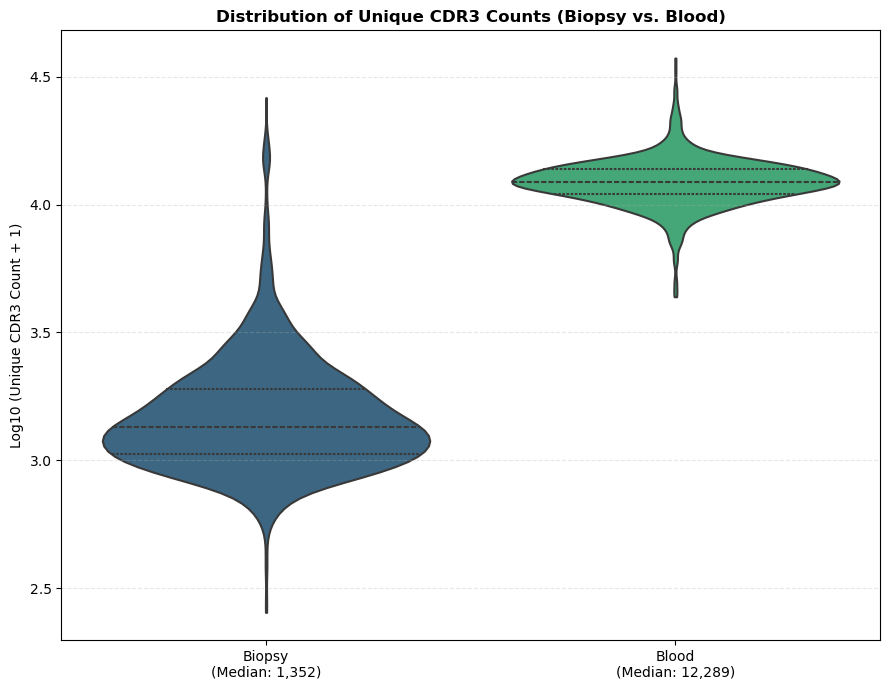

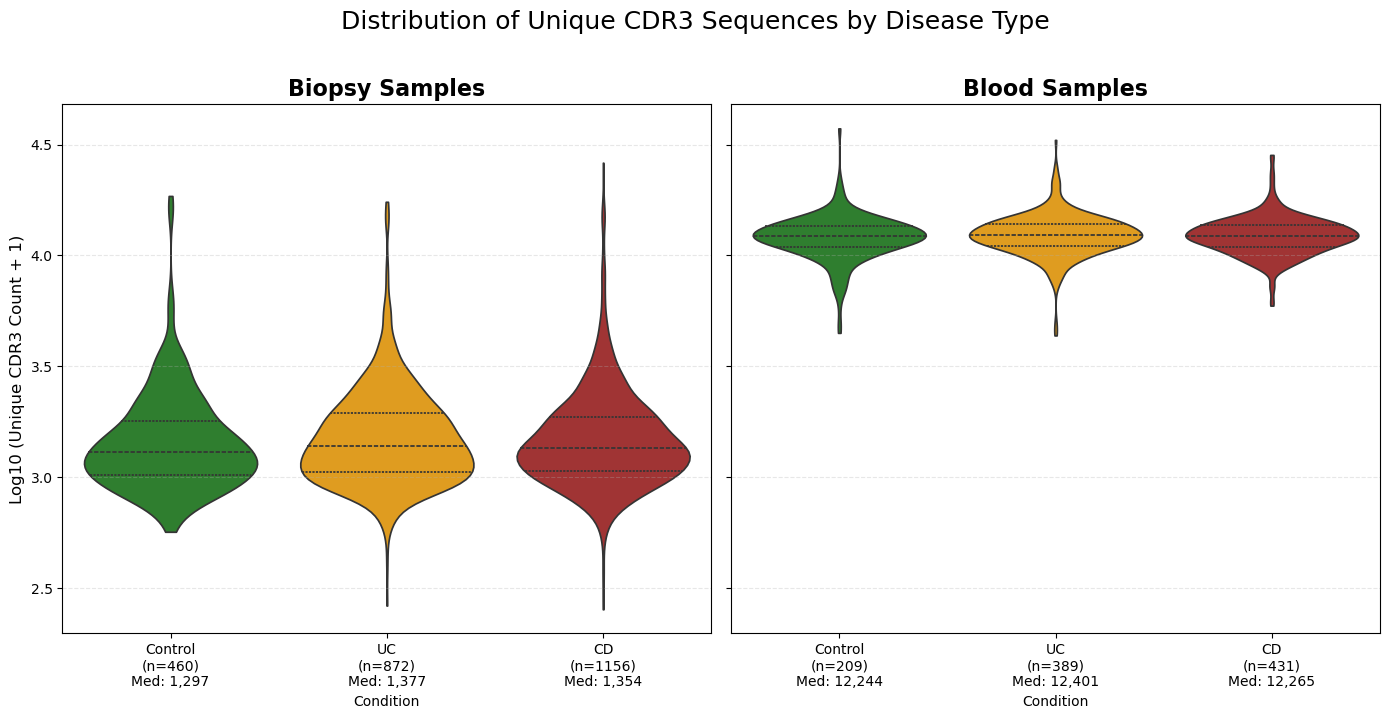

In [4]:
# 1. Load or Generate Metadata
if os.path.exists(METADATA_OUTPUT) and not FORCE_RELOAD:
    print(f"--- Loading Metadata from {os.path.basename(METADATA_OUTPUT)} ---")
    meta_df = pd.read_csv(METADATA_OUTPUT)
else:
    meta_df = generate_full_metadata()

# 2. Load Count Data
df_biopsy = load_counts("Biopsy", FORCE_RELOAD)
df_blood = load_counts("Blood", FORCE_RELOAD)

# 3. Merge with Metadata
dfs_with_meta = []
if not df_biopsy.empty:
    dfs_with_meta.append(merge_counts_with_metadata(df_biopsy, meta_df, "Biopsy"))
if not df_blood.empty:
    dfs_with_meta.append(merge_counts_with_metadata(df_blood, meta_df, "Blood"))

# 4. Generate Both Plots
if dfs_with_meta:
    final_df = pd.concat(dfs_with_meta, ignore_index=True)
    
    print("\n--- Generating Visualizations ---")
    
    # Plot 1: General (Biopsy vs Blood)
    # Note: We use the merged dataframe here too, so we are sure the data is consistent
    plot_general_comparison(final_df)
    
    # Plot 2: Stratified (Split by Disease)
    plot_stratified_comparison(final_df)
else:
    print("❌ No matching data found to plot.")

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import pandas as pd
import pickle

# ================= CONFIGURATION =================
CDR3_COLUMN_NAME = "CDR3_match" 
OUTPUT_FOLDER = "plots" # The folder where images will be saved
CACHE_DIR = "."         # Where to save the intermediate .pkl files

# Define your datasets
# Assumes 'PATHS' variable is already defined in your environment
datasets_to_process = {
    "Blood": PATHS['Blood']["raw_counts"],
    "Biopsy": PATHS['Biopsy']["raw_counts"]
}

# ================= HELPER FUNCTIONS =================

def get_lengths_mode(folder_path, dataset_name, mode="total"):
    """
    mode: 'total' (Abundance) or 'unique' (Diversity)
    """
    # Create specific cache name so they don't mix
    cache_filename = os.path.join(CACHE_DIR, f"cache_{dataset_name}_{mode}.pkl")
    
    # 1. CHECK CACHE
    if os.path.exists(cache_filename):
        print(f"    > [CACHE HIT] Loading {mode} data for {dataset_name}...")
        with open(cache_filename, 'rb') as f:
            return pickle.load(f)

    # 2. PROCESS FILES
    print(f"    > [PROCESSING] Reading {dataset_name} ({mode})...")
    files = glob.glob(os.path.join(folder_path, "*.parquet"))
    lengths_list = []
    
    for i, file_path in enumerate(files):
        try:
            # Read column
            df = pd.read_parquet(file_path, columns=[CDR3_COLUMN_NAME])
            
            # --- LOGIC SWITCH ---
            if mode == "unique":
                # DIVERSITY: Drop duplicates first
                data_to_count = df[CDR3_COLUMN_NAME].drop_duplicates()
            else:
                # ABUNDANCE: Keep everything
                data_to_count = df[CDR3_COLUMN_NAME]
            
            # Calculate lengths
            curr_lengths = data_to_count.str.len()
            
            # Filter biologically valid range (keeps 8 for now so you can see the noise)
            valid = curr_lengths[(curr_lengths > 5) & (curr_lengths < 30)]
            
            lengths_list.extend(valid.tolist())
            
        except:
            pass
            
    # 3. SAVE CACHE
    with open(cache_filename, 'wb') as f:
        pickle.dump(lengths_list, f)
        
    return lengths_list

def plot_thesis_graph(lengths, dataset_name, mode):
    if not lengths: return

    plt.figure(figsize=(10, 6))
    
    # Color settings
    bar_color = 'skyblue' if mode == 'total' else 'lightgreen'
    title_suffix = "Abundance (Total Counts)" if mode == 'total' else "Diversity (Unique Sequences)"
    y_label = "Total Count (Log Scale)" if mode == 'total' else "Unique Clones (Log Scale)"
    
    # Plot Histogram
    sns.histplot(lengths, bins=range(5, 31), kde=False, color=bar_color, edgecolor='black', alpha=0.7)
    
    plt.yscale('log')
    
    # Formatting
    count_str = f"{len(lengths):,}"
    plt.title(f'{dataset_name} CDR3 Length - {title_suffix}\n(N = {count_str})', fontsize=14)
    plt.xlabel('Length (Amino Acids)', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.xticks(range(5, 31))
    
    # --- CHANGE IS HERE: Comment out this line to remove background lines ---
    # plt.grid(axis='y', which='both', alpha=0.3) 
    
    # Save
    filename = f"{dataset_name}_{mode}_LogScale_NoGrid.png"
    save_path = os.path.join(OUTPUT_FOLDER, filename)
    
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"    > Graph saved: {save_path}")

# ================= MAIN EXECUTION =================

print("--- Starting Thesis Graph Generation ---")

# 1. Create the 'plots' folder automatically if it doesn't exist
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

for name, folder_path in datasets_to_process.items():
    print(f"\nAnalyzing {name}...")
    
    # 1. Generate TOTAL (Every Count) Graph
    total_data = get_lengths_mode(folder_path, name, mode="total")
    plot_thesis_graph(total_data, name, mode="total")
    
    # 2. Generate UNIQUE (Diversity) Graph
    unique_data = get_lengths_mode(folder_path, name, mode="unique")
    plot_thesis_graph(unique_data, name, mode="unique")

print("\n--- Done! Check your 'plots' folder for 4 images ---")

--- Starting Thesis Graph Generation ---

Analyzing Blood...
    > [CACHE HIT] Loading total data for Blood...
    > Graph saved: plots/Blood_total_LogScale_NoGrid.png
    > [CACHE HIT] Loading unique data for Blood...
    > Graph saved: plots/Blood_unique_LogScale_NoGrid.png

Analyzing Biopsy...
    > [CACHE HIT] Loading total data for Biopsy...
    > Graph saved: plots/Biopsy_total_LogScale_NoGrid.png
    > [CACHE HIT] Loading unique data for Biopsy...
    > Graph saved: plots/Biopsy_unique_LogScale_NoGrid.png

--- Done! Check your 'plots' folder for 4 images ---
